## Import libraries

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import time
import pylab as pl
import gmsh
from IPython import display
from matplotlib.path import Path
from scipy.sparse import coo_array
from collections import Counter
%matplotlib inline
import scipy
import time
from multiprocessing import Manager,Pool
from worker1 import matrix_helper
from worker2 import picard_helper
import gc

## Utility functions

In [7]:
def read_mesh(filepath):
    '''
    Takes in an msh file and should return nodal coordinates and element connectivity in each physical group along with the boundary nodes 
    '''
    gmsh.initialize()
    gmsh.open(filepath)
    print(f"Reading {filepath}")
    print(f"Number of nodes in the mesh: {int(gmsh.option.getNumber("Mesh.NbNodes"))}")
    print(f"Number of triangles in the mesh: {int(gmsh.option.getNumber("Mesh.NbTriangles"))}\n")

    #Get all nodes
    dim = -1
    tag = -1
    nodeTags, nodecoords, _ = gmsh.model.mesh.getNodes(dim,tag)
    nodecoords = nodecoords.reshape(-1,3) #tags start from 1

    #Get all triangles
    eleType = 2
    tag = -1
    elements_t,ele_con = gmsh.model.mesh.getElementsByType(eleType,-1)
    ele_con = ele_con.reshape(-1,3)  #tags start from 1


    gmsh.finalize()
    return [nodecoords,ele_con] 

In [8]:
''' Functions relating to source term and the properties of Titanium alloy '''
def Q(point,centre,ro):
    x = point[0,0] - centre[0,0]
    y = point[0,1] - centre[0,1]
    Qo = 5 ## amplitude in W/mm^2 
    return Qo*np.exp(-(x**2+y**2)/ro**2)  ## W/m^3

def rho_Ti(T, phase = 'alpha'):
    if phase == 'alpha':
        return -5.13e-5*(T**2)-0.01935*T+4451
    elif phase == 'beta':
        return -2.762e-6*(T**2)-0.1663*T+4468
    elif phase == 'liquid':
        return -0.565*T+5093
    else:
        return T

def cp_Ti(T,phase = 'alpha'):
    if phase == 'alpha':
        return 0.25*T+483
    elif phase == 'beta':
        return 0.14*T+530
    elif phase == 'liquid':
        return 930
    else:
        return T

def k_Ti(T,phase = 'alpha'):
    if phase == 'alpha':
        return 0.012*T+3.3
    elif phase == 'beta':
        return 0.016*T-3
    elif phase == 'liquid':
        return 0.0175*T-4.5
    else:
        return T

def props_chooser(T, T_rep, process = 'heating'):
    if (T_rep<1268 and process == 'heating') or (T_rep<=1073 and process == 'cooling'):
        return rho_Ti(T,phase = 'alpha'),cp_Ti(T,phase = 'alpha'),k_Ti(T,phase = 'alpha')
    elif (T_rep<1928 and process == 'heating') or (T_rep>1073 and process == 'cooling'):
        return rho_Ti(T,phase = 'beta'),cp_Ti(T,phase = 'beta'),k_Ti(T,phase = 'beta')
    elif (T_rep>=1928 and process == 'heating') or (T_rep>=1878 and process == 'cooling'):
        return rho_Ti(T,phase = 'liquid'),cp_Ti(T,phase = 'liquid'),k_Ti(T,phase = 'liquid')
    else:
        return -1
  

In [9]:
'''Parallel processing utility functions'''
def flatten(xss):
    return [x for xs in xss for x in xs] 

## Validation of quasi-static solver code

In [82]:
class FEM:
    def __init__(self,nodecoords,elecon,centre):
        self.data_line = {"ips":{2:[-1/np.sqrt(3),1/np.sqrt(3)],3:[-np.sqrt(3/5),0,np.sqrt(3/5)]},\
        "weights":{2:[1,1],3:[5/9,8/9,5/9]}}
        self.data_tle = {"ips":{1:[[1/3,1/3]],3:[[1/6,1/6],[1/6,2/3],[2/3,1/6]]},\
       "weights":{1:[1/2],3:[1/6,1/6,1/6]}}
        self.nodecoords = nodecoords
        self.elecon = elecon
        self.centre = centre
    
    def fit_ele(self,theta_prev_time = None,theta_prev_pic = None,mode = "linear",verbose = False):
        '''
        Return mass and stiffness matrices alongside the forcing vector
        '''

        nodes = self.nodecoords
        ele = self.elecon
        source = self.centre

        #getting the boundary nodes
        
        ln = np.where(nodes[:,0] == 0)[0]
        rn = np.where(nodes[:,0] == np.max(nodes[:,0]))[0]
        bn = np.where(nodes[:,1] == 0)[0]
        tn = np.where(nodes[:,1] == np.max(nodes[:,1]))[0]

        #Data for FEA
        gp = 3
        nop = nodes.shape[0]
        ips = np.array(self.data_tle["ips"][gp])
        weights = np.array(self.data_tle["weights"][gp])

        K_row,K_col,K_data = [],[],[]
        G_row,G_col,G_data = [],[],[]

        #Parallel processing for matrix computations
        items = [(nodes,elei,source,theta_prev_time,theta_prev_pic,mode) for elei in ele]
        st = time.time()
        with Pool(processes = 4) as pool:
            results = pool.map(matrix_helper, items)
        if verbose == True:
            print(f"Time for pooling to end {time.time()-st}")

        #Accumulating data collected over multiprocessing
        st = time.time()
        K_row, K_col, K_data, G_row, G_col, G_data, F_row,F_data, BT_row, BT_data,areas = list(zip(*results))
        mega = [K_row, K_col, K_data, G_row, G_col, G_data, F_row,F_data, BT_row, BT_data]
        K_row, K_col, K_data, G_row, G_col, G_data, F_row,F_data, BT_row, BT_data = [flatten(mini) for mini in mega]
        if verbose == True:
            print(f"Time for accumulation of data to end {time.time()-st}")

        h = np.sqrt(np.mean(areas)) 
        if verbose == True:
            print(f"Mesh size is {h} mm")
            print(f"Spot radius is 2 mm")

        #Preparing the matrices for calculations
        st = time.time()
        F= coo_array((F_data,(F_row,[0]*len(F_row))),shape = ((nop,1))).toarray()
        boundary_term = coo_array((BT_data,(BT_row,[0]*len(BT_row))),shape = ((nop,1))).toarray()
        
        K_sparse = coo_array((K_data,(K_row,K_col)),shape=(nop,nop))
        G_sparse = coo_array((G_data,(G_row,G_col)),shape=(nop,nop))
        if verbose == True:
            print(f"Time for matrices creation {time.time()-st}")

        #Converting sparse to dense matrix for submatrix extractions
        st = time.time()
        K = K_sparse.toarray()
        G = G_sparse.toarray()

        if mode == "no_source":
            F = np.zeros((nop,1))
            G = np.zeros((nop,nop))
        if verbose == True:
            print(f"Time for sparse to dense conversion {time.time()-st}")

        #Setting up the right hand side by subtracting the dirichlet terms
        T_l = 20
        non_ln = np.setdiff1d(np.arange(K.shape[0]),ln)
        rhs = F+boundary_term-T_l*np.sum((K[np.ix_(np.arange(K.shape[0]),ln)]\
                                          +G[np.ix_(np.arange(K.shape[0]),ln)]),axis = 1).reshape(-1,1)

        #Sub matrix extractions
        K_sub = K[np.ix_(non_ln,non_ln)]
        G_sub = G[np.ix_(non_ln,non_ln)]
        rhs_sub = rhs[np.ix_(non_ln,[0])]

        #Back to sparse matrix for efficient inverse computation
        K_sparse = coo_array(K_sub)
        G_sparse = coo_array(G_sub)
        rhs_sparse = coo_array(rhs_sub)
        
        st = time.time()
        theta_sub = scipy.sparse.linalg.spsolve(K_sparse+G_sparse,rhs_sparse)
        if verbose == True:
            print(f"Time for inversion {time.time()-st}")

        #Final solution with the dirichlet imposed
        theta = np.zeros((K.shape[0],1))+T_l
        theta[non_ln,:] = theta_sub.reshape(-1,1)
        
        return [h,K,G,F,boundary_term,theta]


In [39]:
filename = f"rectangle_vary_0.5_1.msh"
nodecoords,ele_con = read_mesh(filename) #node tags start from 1
soln1 = FEM(nodecoords,ele_con,np.array([[50,25]]))

Reading rectangle_vary_0.5_1.msh
Number of nodes in the mesh: 9806
Number of triangles in the mesh: 19286



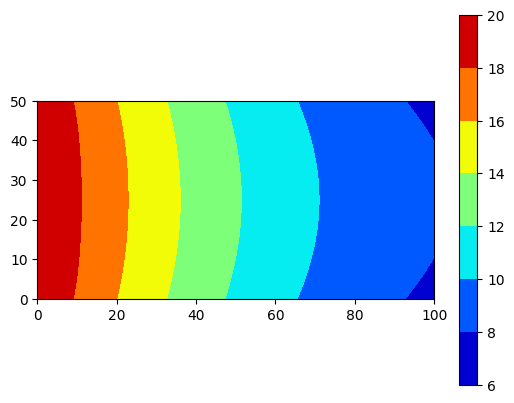

In [40]:
h,K,G,F,boundary,theta = soln1.fit_ele(mode = "no_source",verbose = False)
gc.collect()
plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta.flatten(),cmap = 'jet')
plt.colorbar()
plt.gca().set_aspect('equal')
plt.show()

In [36]:
print(f"The maximum temperature is {np.max(theta):.2f} K and the minimum temperature is {np.min(theta):.2f} K")

The maximum temperature is 20.17 K and the minimum temperature is 15.00 K


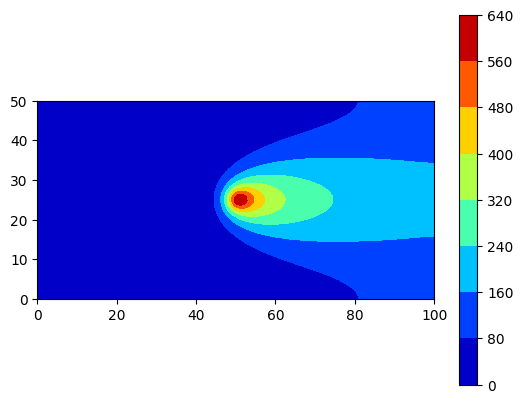

In [41]:
K,G,F,boundary,theta = soln1.fit_ele(verbose = False)
gc.collect()
plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta.flatten(),cmap = 'jet')
plt.colorbar()
plt.gca().set_aspect('equal')
plt.show()

In [42]:
print(f"The maximum temperature is {np.max(theta):.2f} K and the minimum temperature is {np.min(theta):.2f} K")

The maximum temperature is 630.49 K and the minimum temperature is 19.63 K


## Validation of picard iteration

In [43]:
def Q(point):
    x = point[0,0] #in mm
    return 15e-3*(x/100)*(1-x/100) ## W/mm^3

def k_T(T):
    # return np.ones_like(T)*110
    return (100+0.004*(T-50-273)**2)*1e-3  ##W/mmK

In [68]:
class Picard_valid:
    def __init__(self,nodecoords,elecon):
        self.data_line = {"ips":{2:[-1/np.sqrt(3),1/np.sqrt(3)],3:[-np.sqrt(3/5),0,np.sqrt(3/5)]},\
        "weights":{2:[1,1],3:[5/9,8/9,5/9]}}
        self.data_tle = {"ips":{1:[[1/3,1/3]],3:[[1/6,1/6],[1/6,2/3],[2/3,1/6]]},\
       "weights":{1:[1/2],3:[1/6,1/6,1/6]}}
        self.nodecoords = nodecoords
        self.elecon = elecon
                        
    def fit_ele(self,dt,theta_prev_time = None,theta_prev_pic = None,mode = "linear",scheme = "implicit",verbose = False):
        '''
        Return mass and stiffness matrices alongside the forcing vector
        '''
        gp = 3

        qo = 0   # W/mm^2
        c = 465 #J/kg.K
        rho = 7e-6 #kg/mm^3

        nodes = self.nodecoords
        ele = self.elecon
        
        ln = np.where(nodes[:,0] == 0)[0]
        rn = np.where(nodes[:,0] == np.max(nodes[:,0]))[0]
        bn = np.where(nodes[:,1] == 0)[0]
        tn = np.where(nodes[:,1] == np.max(nodes[:,1]))[0]
        
        nop = nodes.shape[0]
        ips = np.array(self.data_tle["ips"][gp])
        weights = np.array(self.data_tle["weights"][gp])

        K_row,K_col,K_data = [],[],[]
        M_row,M_col,M_data = [],[],[]

        #Parallel processing for matrix computations
        items = [(nodes,elei,theta_prev_time,theta_prev_pic,mode,scheme) for elei in ele]
        st = time.time()
        with Pool(processes = 4) as pool:
            results = pool.map(picard_helper, items)
        if verbose == True:
            print(f"Time for pooling to end {time.time()-st}")

        #Accumulating data collected over multiprocessing
        st = time.time()
        K_row, K_col, K_data, M_row, M_col, M_data, F_row,F_data,areas = list(zip(*results))
        mega = [K_row, K_col, K_data, M_row, M_col, M_data, F_row,F_data]
        K_row, K_col, K_data, M_row, M_col, M_data, F_row,F_data = [flatten(mini) for mini in mega]
        if verbose == True:
            print(f"Time for accumulation of data to end {time.time()-st}")

        #Preparing the matrices for calculations
        st = time.time()
        F= coo_array((F_data,(F_row,[0]*len(F_row))),shape = ((nop,1))).toarray()
        
        K_sparse = coo_array((K_data,(K_row,K_col)),shape=(nop,nop))
        M_sparse = coo_array((M_data,(M_row,M_col)),shape=(nop,nop))
        if verbose == True:
            print(f"Time for matrices creation {time.time()-st}")

        #Converting sparse to dense matrix for submatrix extractions
        st = time.time()
        K = K_sparse.toarray()
        M = M_sparse.toarray()

        if verbose == True:
            print(f"Time for sparse to dense conversion {time.time()-st}")
        
        #setting up the right hand side
        T_b = 273+100
        non_bn = np.setdiff1d(np.arange(K.shape[0]),bn)
        rhs = (F+M@theta_prev_time/dt)\
               -T_b*np.sum(K[np.ix_(np.arange(K.shape[0]),bn)]+M[np.ix_(np.arange(K.shape[0]),bn)]/dt,axis = 1).reshape(-1,1)
        
        K_sub = K[np.ix_(non_bn,non_bn)]
        M_sub = M[np.ix_(non_bn,non_bn)]
        rhs_sub = rhs[np.ix_(non_bn,[0])]
        theta_sub = np.linalg.inv(K_sub+M_sub/dt)@(rhs_sub)

        theta = np.zeros((K.shape[0],1))+T_b
        theta[non_bn,:] = theta_sub.reshape(-1,1)
        
        return [M,K,F,theta]

In [71]:
def picard(soln,nodecoords,ele_con,theta_init):
    dt = 1
    times = np.arange(0,10,dt)
    theta_prev_time = theta_init
    
    for t in times:
        e = 1e5
        tolerance = 1e-4
        iter = 0
        theta_prev_pic = theta_prev_time
        while(e>tolerance):
            iter +=1
            M,K,F,theta_new = soln.fit_ele(dt,theta_prev_time = theta_prev_time,theta_prev_pic = theta_prev_pic,mode = "non_linear",scheme = "implicit")
            e = np.linalg.norm(theta_new - theta_prev_pic)
            theta_prev_pic = theta_new
            if t == round(t):
                print(f"Error at {iter} iteration at time {t} is {e:.2E}")
        theta_prev_time = theta_new
        
    plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta_new.flatten()-273, cmap = 'jet')
    plt.title(f"Converged solution")
    plt.colorbar()
    plt.show()

    return theta_new
        

Reading square_3.msh
Number of nodes in the mesh: 380
Number of triangles in the mesh: 690

Error at 1 iteration at time 0 is 2.34E+02
Error at 2 iteration at time 0 is 3.52E+00
Error at 3 iteration at time 0 is 3.69E-02
Error at 4 iteration at time 0 is 2.79E-04
Error at 5 iteration at time 0 is 1.79E-06
Error at 1 iteration at time 1 is 6.46E+01
Error at 2 iteration at time 1 is 4.82E-01
Error at 3 iteration at time 1 is 2.65E-03
Error at 4 iteration at time 1 is 1.24E-05
Error at 1 iteration at time 2 is 4.52E+01
Error at 2 iteration at time 2 is 2.56E-01
Error at 3 iteration at time 2 is 1.29E-03
Error at 4 iteration at time 2 is 1.17E-05
Error at 1 iteration at time 3 is 3.69E+01
Error at 2 iteration at time 3 is 1.62E-01
Error at 3 iteration at time 3 is 9.17E-04
Error at 4 iteration at time 3 is 8.05E-06
Error at 1 iteration at time 4 is 3.23E+01
Error at 2 iteration at time 4 is 1.15E-01
Error at 3 iteration at time 4 is 6.96E-04
Error at 4 iteration at time 4 is 5.51E-06
Error

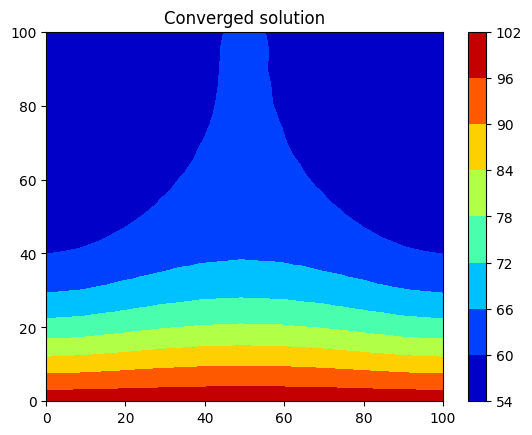

In [72]:
mesh_size_factor = 3
filename = f"square_{mesh_size_factor}.msh"
nodecoords,ele_con = read_mesh(filename) 
soln3 = Picard_valid(nodecoords,ele_con)
T_b = 273+50
theta_init = np.zeros((nodecoords.shape[0],1))+T_b
theta_final = picard(soln3,nodecoords,ele_con,theta_init)

In [77]:
Ta = theta_final[np.where((nodecoords[:,0] == 0) * (nodecoords[:,1] == 100)) [0][0]]-273
Tb = theta_final[np.where((nodecoords[:,0] == 100) * (nodecoords[:,1] == 100)) [0][0]]-273
print(f"The temperature at node a is {Ta[0]:.2f}K and at node b is {Tb[0]:.2f}K")

The temperature at node a is 54.74K and at node b is 54.74K


## Mesh convergence

Reading rectangle_2.msh
Number of nodes in the mesh: 1542
Number of triangles in the mesh: 2932

Reading rectangle_4.msh
Number of nodes in the mesh: 425
Number of triangles in the mesh: 772

Reading rectangle_6.msh
Number of nodes in the mesh: 208
Number of triangles in the mesh: 362



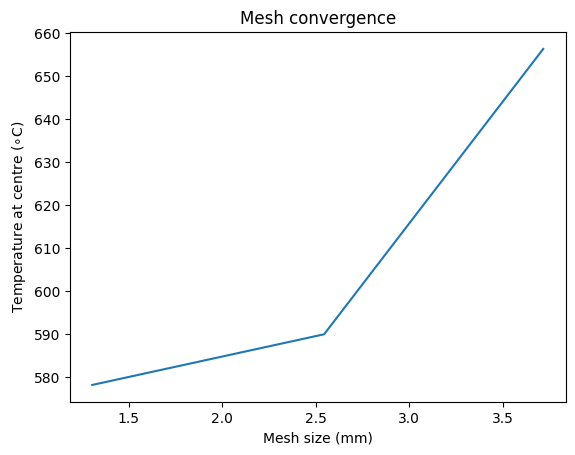

In [93]:
# mesh_name_format = "rectangle_{}.msh"
mesh_names = ["rectangle_2.msh","rectangle_4.msh","rectangle_6.msh"]
rep = np.array([50,25,0]).reshape(1,-1)

mesh_sizes = []
T_reps = []
for mesh_name in mesh_names:
    nodecoords,ele_con = read_mesh(mesh_name)
    soln1 = FEM(nodecoords,ele_con,np.array([[50,25]]))
    h,K,G,F,boundary,theta = soln1.fit_ele(mode = "linear",verbose = False)
    mesh_sizes.append(h)

    distances = np.sum(np.square(nodecoords-rep),axis = 1)
    closest = np.argmin(distances)
    T_reps.append(theta[closest])

plt.plot(mesh_sizes,T_reps)
plt.title('Mesh convergence')
plt.xlabel('Mesh size (mm)')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()
    
    

## Final solution

In [94]:
def picard(nodecoords,ele_con,theta_init,source):
## the idea is you initialize a temperature profile and find corresponding multipliers for the non linear terms
    #non is number of nodes
    theta_old = theta_init

    e = 1e5
    tolerance = 1e-4
    iter = 0
    
    while(e>tolerance):
        iter +=1
        _,_,_,_,theta_new = FEM(nodecoords,ele_con,source).fit_ele(nodecoords,ele_con,theta_prev_time = theta_init,theta_prev_pic = theta_old,mode = "non_linear")
        e = np.linalg.norm(theta_new - theta_old)
        theta_old = theta_new
        print(f"Error at {iter} iteration is {e:.2E}")
        # print(theta_init)

    plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta_new.flatten())
    plt.title(f"Converged solution after {iter} iterations")
    plt.colorbar()
    plt.show()

    return theta_new

In [ ]:
converged_mesh = 
nodecoords,ele_con = read_mesh(converged_mesh)

In [ ]:
T_l = 273+500
vo = 2 #mm/s
t_final = 10
times = np.arange(0,t_final,1)
theta_init = np.zeros((nodecoords.shape[0],1))+T_l
theta_prev = theta_init
#Let's move the source
x_source = 50
for t in times:
    print(f"Time is {t} seconds")
    theta_final = picard(nodecoords,ele_con,theta_prev,source = np.array([[x_source+vo*t,25]]))
    theta_prev = theta_final